# 04. PyTorch Custom Datasets Exercises

## Resources

These exercises/solutions are based on https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [1]:
# Import torch
import torch
from torch import DeviceObjType, nn

print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
print(device)

2.7.1
mps


## 2. Recreate the data loading functions

### 1. Get data


In [2]:
from pathlib import Path

# Set up paths
data_path = Path("data/")
image_path = data_path  / "pizza-steak-sushi"

# Create data dir if does not exits
if image_path.is_dir():
    print(f"{image_path} already exists...")
else:
    print(f"{image_path} doesn't exist, creating...")
    image_path.mkdir(exist_ok=True)

data/pizza-steak-sushi already exists...


In [3]:
import requests

# Download data
with open(data_path / "pizza-steak-sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza-steak-sushi.zip...")
    f.write(request.content)

TimeoutError: [Errno 60] Operation timed out

In [ ]:
from zipfile import ZipFile

# Extract data
with ZipFile(data_path / "pizza-steak-sushi.zip", "r") as z:
    print(f"Extracting pizza-steak-sushi.zip...")
    z.extractall(image_path)

Extracting pizza-steak-sushi.zip...


### 2. Become one with the data

In [ ]:
import os

def walk_through_files(dir_path) -> None:
    """Walks through dir_path printing file counts of its content"""
    for dir_path, dir_names, file_names in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories and {len(file_names)} files in {dir_path}")

# Walk through data folder
walk_through_files(image_path)

There are 2 directories and 0 files in data/pizza-steak-sushi
There are 3 directories and 0 files in data/pizza-steak-sushi/test
There are 0 directories and 19 files in data/pizza-steak-sushi/test/steak
There are 0 directories and 31 files in data/pizza-steak-sushi/test/sushi
There are 0 directories and 25 files in data/pizza-steak-sushi/test/pizza
There are 3 directories and 0 files in data/pizza-steak-sushi/train
There are 0 directories and 75 files in data/pizza-steak-sushi/train/steak
There are 0 directories and 72 files in data/pizza-steak-sushi/train/sushi
There are 0 directories and 78 files in data/pizza-steak-sushi/train/pizza


In [ ]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('data/pizza-steak-sushi/train'),
 PosixPath('data/pizza-steak-sushi/test'))

Image path: data/pizza-steak-sushi/test/pizza/2236338.jpg
Image label: pizza
Image width: 512
Image height: 512
Image size: (512, 512)


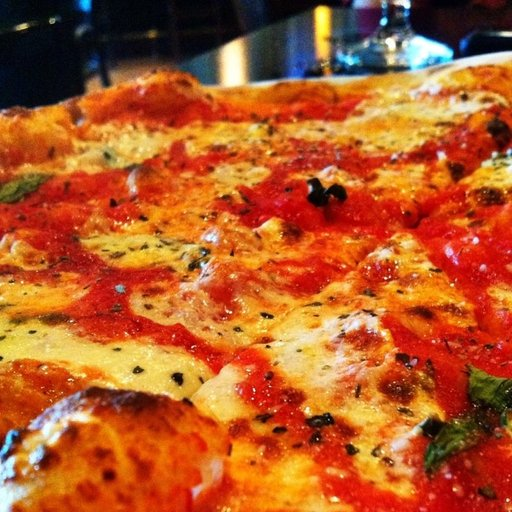

In [ ]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
sample_image = Image.open(sample_path)
sample_label = sample_path.parent.stem

print(f"Image path: {sample_path}")
print(f"Image label: {sample_label}")
print(f"Image width: {sample_image.width}")
print(f"Image height: {sample_image.height}")
print(f"Image size: {sample_image.size}")
sample_image

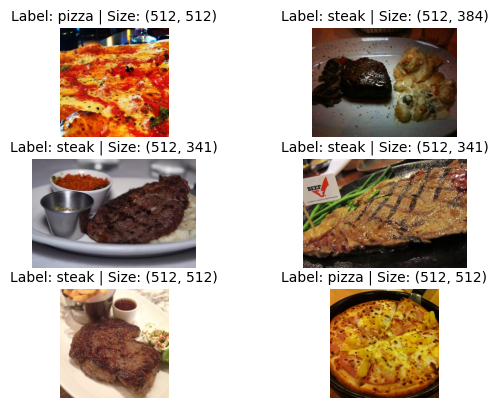

In [ ]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt

random.seed(42)

for i in range(1, 7):
    sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
    sample_label = sample_path.parent.stem
    sample_image = Image.open(sample_path)
    
    plt.subplot(3, 2, i)
    plt.imshow(sample_image)
    plt.title(f"Label: {sample_label} | Size: {sample_image.size}", fontsize=10)
    plt.axis(False)

### 2.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write transform for turning images into tensors
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# Write a function to plot transformed images
def plot_and_transform_images_v1(image_path, transforms, nrows: int, seed: int=42):
    random.seed(seed)
    
    sample_paths = random.sample(list(image_path.glob("*/*/*.jpg")), k=nrows)
    
    for sample_path in sample_paths:
        sample_label = sample_path.parent.stem
        
        original_image = Image.open(sample_path)
        transformed_image = transforms(original_image).permute(1, 2, 0)
        
        fig, ax = plt.subplots(1, 2)
        
        ax[0].imshow(original_image)
        ax[0].set_title(f"Original image\nSize: {original_image.size}")
        ax[0].axis(False)
        
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Original image\nSize: {transformed_image.shape}")
        ax[1].axis(False)

plot_and_transform_images_v1(
    image_path=image_path,
    transforms=image_transform,
    nrows=3, 
    seed=42
)

NameError: name 'image_transform' is not defined

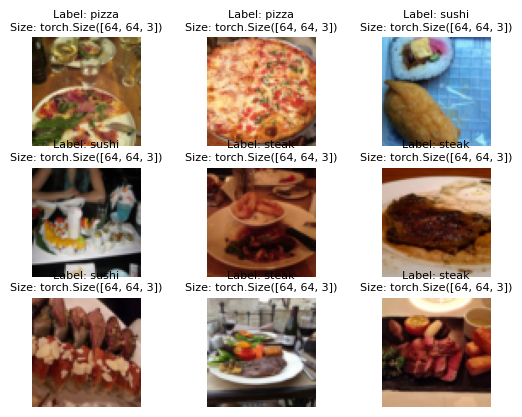

In [ ]:
# Write a function to plot transformed images
def plot_and_transform_images_v2(image_path, transforms, nrows: int, ncols: int, seed: int=42):
    for i in range(1, nrows*ncols + 1):
        sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
        sampel_label = sample_path.parent.stem
        sample_image = Image.open(sample_path)
        
        sample_transformer_image = transforms(img=sample_image).permute(1, 2, 0)
        
        plt.subplot(nrows, ncols, i)
        plt.imshow(sample_transformer_image)
        plt.title(f"Label: {sampel_label}\nSize: {sample_transformer_image.shape}", fontsize=8)
        plt.axis(False)
        
plot_and_transform_images_v2(
    image_path=image_path,
    transforms=test_transform,
    nrows=3, 
    ncols=3,
    seed=42
)

### 2.2 Load image data using `ImageFolder`

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:

1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_folder = ImageFolder(
    root=train_path,
    transform=test_transform
)

test_folder = ImageFolder(
    root=test_path,
    transform=train_transform
)

train_folder, test_folder

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
classes = train_folder.classes
classes

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
classes_to_idx = train_folder.class_to_idx
classes_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_folder), len(test_folder)

(225, 75)

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_folder,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_dataloader = DataLoader(
    dataset=test_folder,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11b173cb0>,
 <torch.utils.data.dataloader.DataLoader at 0x11b404050>)

In [ ]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0`

In [ ]:
from torch import nn

class Model_0(nn.Module):
    def __init__(self, in_features: int, hidden_units: int, out_features: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_features,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),   
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 16 * 16,
                out_features=out_features,
            )
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(x.shape)
        
        x = self.conv_block_2(x)
        # print(x.shape)
        
        x = self.classifier(x)
        # print(x.shape)
        
        return x

model_0 = Model_0(
    in_features=3,
    hidden_units=8,
    out_features=len(classes)
).to(device)

model_0

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [ ]:
model_0

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

model_0(image_batch)

tensor([[-0.0057,  0.0620, -0.0111],
        [-0.0060,  0.0502, -0.0065],
        [-0.0091,  0.0556, -0.0127],
        [-0.0046,  0.0502, -0.0111],
        [-0.0014,  0.0548, -0.0082],
        [-0.0122,  0.0515, -0.0103],
        [-0.0113,  0.0499, -0.0133],
        [-0.0062,  0.0532, -0.0120],
        [-0.0044,  0.0545, -0.0093],
        [-0.0015,  0.0530, -0.0154],
        [-0.0055,  0.0487, -0.0089],
        [-0.0031,  0.0567, -0.0172],
        [-0.0067,  0.0547, -0.0113],
        [-0.0089,  0.0499, -0.0144],
        [-0.0060,  0.0588, -0.0076],
        [-0.0030,  0.0528, -0.0142],
        [-0.0063,  0.0518, -0.0141],
        [-0.0075,  0.0568, -0.0124],
        [-0.0089,  0.0506, -0.0156],
        [-0.0067,  0.0486, -0.0104],
        [-0.0025,  0.0551, -0.0107],
        [-0.0083,  0.0521, -0.0110],
        [-0.0055,  0.0539, -0.0129],
        [-0.0073,  0.0581, -0.0167],
        [-0.0033,  0.0606, -0.0133],
        [-0.0105,  0.0554, -0.0155],
        [-0.0057,  0.0533, -0.0094],
 

## 4. Create training and testing functions for `model_0`

In [ ]:
from typing import Tuple

def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device="cpu",
) -> Tuple[float, float]:
    # Send model to target device
    model.to(device)
    
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy
    train_loss, train_accuracy = 0, 0
    
    # Loop through data loader and data batches
    for X, y in dataloader:
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred_logits = model(X)
        y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

        # 2. Calculate and accumulate loss and accuracy
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()
        
        accuracy = ((y_pred_labels == y).sum().item() / len(y_pred_logits))
        train_accuracy += accuracy
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)
    
    return train_loss, train_accuracy

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device="cpu",
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()
    
    # Setup the test loss and test accuracy
    test_loss, test_accuracy = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            
            # Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            y_pred_logits = model(X)
            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            
            # 2. Calculate and accumulate loss and accuracy
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()
            
            accuracy = ((y_pred_labels == y).sum().item() / len(y_pred_logits))
            test_accuracy += accuracy
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)
    
    return test_loss, test_accuracy

In [ ]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int = 5,
    device="cpu"
):
    # Create results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    
    # Loop through the training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device,
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
        )
        
        # Print out what's happening
        print(
            f"Epoch: {epoch} | ",
            f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.3f}%",
            f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}%"
        )
        
        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    # Return the results dictionary
    return results

## 5. Try training the model for 5, 20 and 50 epochs

In [ ]:
def plot_results(results):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], c="r", label="Train loss")
    plt.plot(results["test_loss"], c="b", label="Test loss")
    plt.title("Train vs test loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], c="r", label="Train accuracy")
    plt.plot(results["test_acc"], c="b", label="Test accuracy")
    plt.title("Train vs test acc")
    plt.legend()
    

In [29]:
# Train for 5 epochs
model_5_epochs = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_5_epochs.parameters(),
    lr=0.001
)

results_5_epochs = train(
    model=model_5_epochs,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1036 | Train acc: 0.250% Test loss: 1.0955 | Test acc: 0.302%
Epoch: 1 |  Train loss: 1.0634 | Train acc: 0.457% Test loss: 1.1542 | Test acc: 0.292%
Epoch: 2 |  Train loss: 1.0874 | Train acc: 0.363% Test loss: 1.0657 | Test acc: 0.354%
Epoch: 3 |  Train loss: 0.9593 | Train acc: 0.566% Test loss: 1.0599 | Test acc: 0.333%
Epoch: 4 |  Train loss: 0.9481 | Train acc: 0.465% Test loss: 1.0874 | Test acc: 0.323%


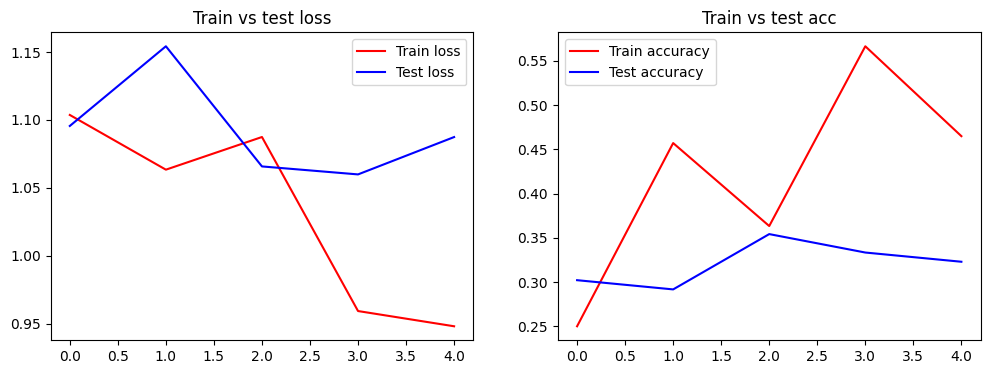

In [30]:
plot_results(results_5_epochs)

In [31]:
# Train for 20 epochs
model_20_epochs = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_20_epochs.parameters(),
    lr=0.001
)

results_20_epochs = train(
    model=model_20_epochs,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1056 | Train acc: 0.250% Test loss: 1.0972 | Test acc: 0.271%
Epoch: 1 |  Train loss: 1.0912 | Train acc: 0.426% Test loss: 1.1080 | Test acc: 0.260%
Epoch: 2 |  Train loss: 1.0836 | Train acc: 0.426% Test loss: 1.1293 | Test acc: 0.260%
Epoch: 3 |  Train loss: 1.1133 | Train acc: 0.305% Test loss: 1.1431 | Test acc: 0.260%
Epoch: 4 |  Train loss: 1.0873 | Train acc: 0.426% Test loss: 1.1318 | Test acc: 0.260%
Epoch: 5 |  Train loss: 1.0982 | Train acc: 0.305% Test loss: 1.1407 | Test acc: 0.260%
Epoch: 6 |  Train loss: 1.0825 | Train acc: 0.461% Test loss: 1.1296 | Test acc: 0.271%
Epoch: 7 |  Train loss: 1.0801 | Train acc: 0.348% Test loss: 1.1266 | Test acc: 0.281%
Epoch: 8 |  Train loss: 1.0692 | Train acc: 0.500% Test loss: 1.0882 | Test acc: 0.352%
Epoch: 9 |  Train loss: 0.9180 | Train acc: 0.633% Test loss: 1.0560 | Test acc: 0.352%
Epoch: 10 |  Train loss: 0.8755 | Train acc: 0.602% Test loss: 1.1294 | Test acc: 0.464%
Epoch: 11 |  Train loss: 0.7846

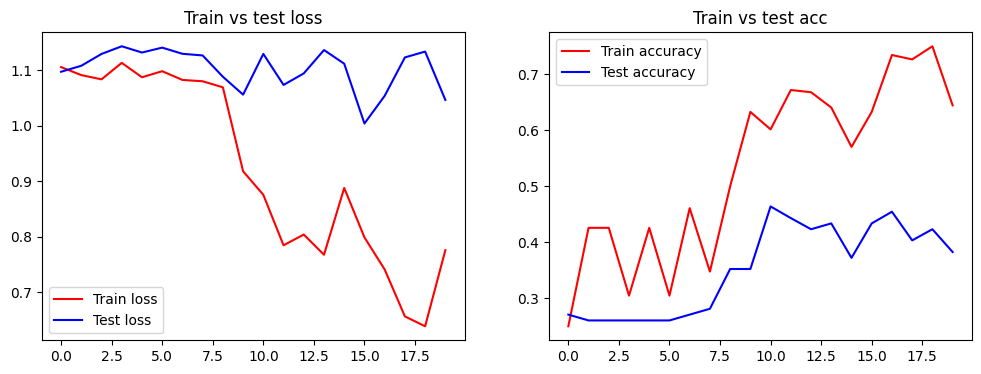

In [32]:
plot_results(results_20_epochs)

In [33]:
# Train for 50 epochs
model_50_epochs = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_50_epochs.parameters(),
    lr=0.001
)

results_50_epochs = train(
    model=model_50_epochs,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1018 | Train acc: 0.406% Test loss: 1.1017 | Test acc: 0.260%
Epoch: 1 |  Train loss: 1.0744 | Train acc: 0.426% Test loss: 1.1407 | Test acc: 0.260%
Epoch: 2 |  Train loss: 1.0837 | Train acc: 0.426% Test loss: 1.1443 | Test acc: 0.260%
Epoch: 3 |  Train loss: 1.1014 | Train acc: 0.305% Test loss: 1.1285 | Test acc: 0.260%
Epoch: 4 |  Train loss: 1.0711 | Train acc: 0.492% Test loss: 1.1135 | Test acc: 0.323%
Epoch: 5 |  Train loss: 1.0784 | Train acc: 0.406% Test loss: 1.1091 | Test acc: 0.292%
Epoch: 6 |  Train loss: 0.9739 | Train acc: 0.535% Test loss: 1.0970 | Test acc: 0.402%
Epoch: 7 |  Train loss: 0.9214 | Train acc: 0.543% Test loss: 1.3496 | Test acc: 0.302%
Epoch: 8 |  Train loss: 1.0554 | Train acc: 0.582% Test loss: 1.0928 | Test acc: 0.422%
Epoch: 9 |  Train loss: 0.9897 | Train acc: 0.418% Test loss: 0.9352 | Test acc: 0.594%
Epoch: 10 |  Train loss: 0.8992 | Train acc: 0.594% Test loss: 1.0611 | Test acc: 0.331%
Epoch: 11 |  Train loss: 0.8342

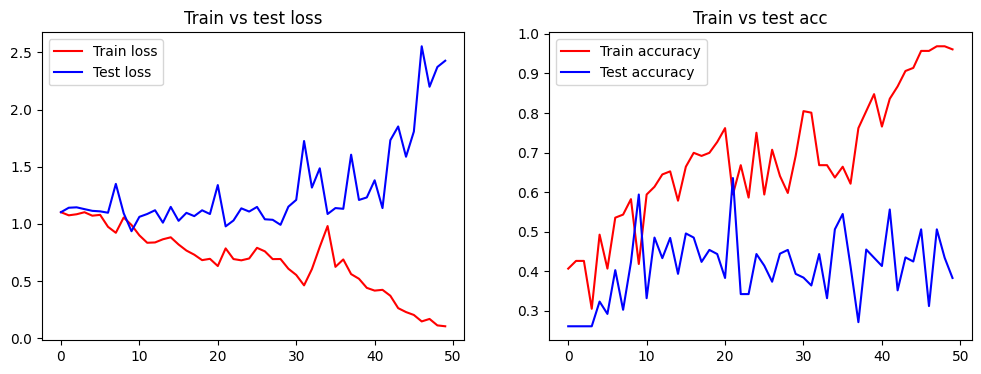

In [34]:
plot_results(results_50_epochs)

## 6. Double the number of hidden units in your model and train it for 20 epochs,

In [35]:
# Double the number of hidden units and train for 20 epochs
model_double_hidden_units = Model_0(
    in_features=3,
    hidden_units=32,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_double_hidden_units.parameters(),
    lr=0.001
)

results_double_hidden_units = train(
    model=model_double_hidden_units,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.0990 | Train acc: 0.402% Test loss: 1.1113 | Test acc: 0.260%
Epoch: 1 |  Train loss: 1.0647 | Train acc: 0.430% Test loss: 1.1182 | Test acc: 0.260%
Epoch: 2 |  Train loss: 1.0783 | Train acc: 0.348% Test loss: 1.1002 | Test acc: 0.302%
Epoch: 3 |  Train loss: 0.9752 | Train acc: 0.555% Test loss: 1.0529 | Test acc: 0.301%
Epoch: 4 |  Train loss: 0.8748 | Train acc: 0.621% Test loss: 1.0455 | Test acc: 0.352%
Epoch: 5 |  Train loss: 0.9275 | Train acc: 0.500% Test loss: 1.3721 | Test acc: 0.382%
Epoch: 6 |  Train loss: 0.8696 | Train acc: 0.613% Test loss: 1.1213 | Test acc: 0.364%
Epoch: 7 |  Train loss: 0.8926 | Train acc: 0.508% Test loss: 0.9956 | Test acc: 0.444%
Epoch: 8 |  Train loss: 0.9176 | Train acc: 0.488% Test loss: 1.0099 | Test acc: 0.444%
Epoch: 9 |  Train loss: 0.8452 | Train acc: 0.477% Test loss: 1.0029 | Test acc: 0.544%
Epoch: 10 |  Train loss: 0.7611 | Train acc: 0.691% Test loss: 1.0445 | Test acc: 0.363%
Epoch: 11 |  Train loss: 0.7358

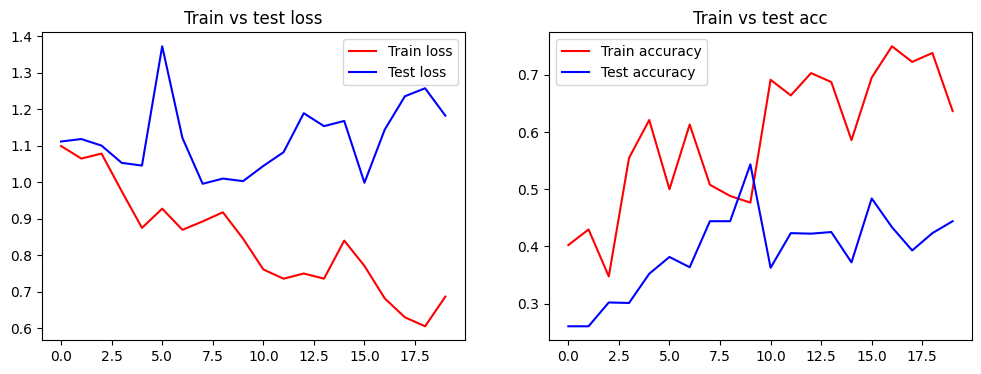

In [36]:
plot_results(results_double_hidden_units)

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs

In [38]:
# Download 20% data for pizza/steak/sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza-steak-sushi-20-percent"

# Create image folder
if image_path.is_dir():
    print(f"{image_path} directory exists...")
else:
    print(f"Did not find {image_path} dictionary, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushu data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data/pizza-steak-sushi-20-percent directory exists...


TimeoutError: [Errno 60] Operation timed out

In [ ]:
# See how many images we have
walk_through_files(image_path)

There are 2 directories and 0 files in data/pizza-steak-sushi-20-percent
There are 3 directories and 0 files in data/pizza-steak-sushi-20-percent/test
There are 0 directories and 58 files in data/pizza-steak-sushi-20-percent/test/steak
There are 0 directories and 46 files in data/pizza-steak-sushi-20-percent/test/sushi
There are 0 directories and 46 files in data/pizza-steak-sushi-20-percent/test/pizza
There are 3 directories and 0 files in data/pizza-steak-sushi-20-percent/train
There are 0 directories and 146 files in data/pizza-steak-sushi-20-percent/train/steak
There are 0 directories and 150 files in data/pizza-steak-sushi-20-percent/train/sushi
There are 0 directories and 154 files in data/pizza-steak-sushi-20-percent/train/pizza


In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza-steak-sushi-20-percent/train'),
 PosixPath('data/pizza-steak-sushi-20-percent/test'))

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

In [ ]:
# Create datasets
from torchvision.datasets import ImageFolder

train_folder = ImageFolder(
    root=train_data_20_percent_path,
    transform=simple_transform,
    target_transform=None,
)

test_folder = ImageFolder(
    root=test_data_20_percent_path,
    transform=simple_transform,
    target_transform=None,
)


In [ ]:
# Create dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_folder,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_dataloader = DataLoader(
    dataset=test_folder,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x118ab56a0>,
 <torch.utils.data.dataloader.DataLoader at 0x10c2a9d10>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(15, 5)

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)

model_double_data = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_double_data.parameters(),
    lr=0.001
)

results_double_data = train(
    model=model_double_data,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device
)

NameError: name 'Model_0' is not defined

In [ ]:
plot_results(results_double_data)

## 8. Make a prediction on your own custom image of pizza/steak/sushi